In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [2]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'num_comments', 'score', 'total_awards',
                          'author_commentkarma', 'compound_score', 'trustworthy', 'sw_1_author_trust',
                          'author_trust', 'author_id', 'author_name',
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y'])

# Apply trust filter
df = df[(df["author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

df

,post_id,date,num_comments,score,total_awards,author_commentkarma,compound_score,author_id,author_name,ticker,...,adjclose_15_Y,adjclose_16_Y,adjclose_17_Y,adjclose_18_Y,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,trustworthy,author_trust,sw_1_author_trust
3,ed0rg2j,2019-01-01,9,6,0.0,744.0,0.3612,2dk1wq99,nightman_123,WSBC,...,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271,1,0.888889,0.638215
92,ed2x6fn,2019-01-02,2,61,0.0,712.0,0.0516,rw1ynq0,martimook,CPSI,...,26.301327,26.496077,26.213688,25.619692,25.366512,25.347040,25.551525,1,0.800000,0.800000
100,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,ABCB,...,34.154694,33.981266,35.175957,36.235764,36.524799,36.476631,36.563339,1,0.857143,0.513544
101,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,CFFN,...,12.251601,12.135600,12.233756,12.198063,11.983905,11.609129,11.559727,1,0.857143,0.506293
120,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,FANG,...,96.537819,96.756943,97.376213,95.556526,95.423157,97.423836,98.243164,1,0.857143,0.513544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940494,ghkrh6s,2020-12-31,1,18,0.0,1283.0,0.3612,ihqbc,keikun2002,WSBC,...,31.364473,31.255468,30.720339,28.926668,29.550983,28.738380,29.313148,1,1.000000,0.443030
940516,ghmxpxm,2020-12-31,0,10,0.0,1283.0,-0.1295,ihqbc,keikun2002,WSBC,...,31.364473,31.255468,30.720339,28.926668,29.550983,28.738380,29.313148,1,1.000000,0.443030
940679,ghldnvu,2020-12-31,0,5,0.0,69.0,0.3818,6mewt3dg,narconocs,EDIT,...,65.760002,65.470001,60.680000,60.500000,61.130001,61.349998,62.889999,1,1.000000,0.357178
940681,ghldnvu,2020-12-31,0,5,0.0,69.0,0.3818,6mewt3dg,narconocs,AUB,...,36.596771,36.010822,34.223194,33.239998,33.359173,32.614326,33.369102,1,1.000000,0.368479


In [3]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'num_comments', 'score', 'total_awards',
       'author_commentkarma', 'compound_score', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust', 'sw_1_author_trust'], dtype=object)

In [4]:
# Find the min and max at 1-4 business week intervals
df['5day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmin(axis=1)

df['10day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmin(axis=1)

df['15day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmin(axis=1)

df['20day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmin(axis=1)

df['5day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmax(axis=1)

df['10day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmax(axis=1)

df['15day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmax(axis=1)

df['20day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmax(axis=1)

# Extract the day number and convert to int
df['5day_min'] = df['5day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_min'] = df['10day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_min'] = df['15day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_min'] = df['20day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['5day_max'] = df['5day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_max'] = df['10day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_max'] = df['15day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_max'] = df['20day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)

In [5]:
# Get the X-variable columns
df_X = df[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score', 'trustworthy', 'author_trust', 'adjclose_20_X',
           'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
           'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
           'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
           'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
           'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X']].to_numpy()

# Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
           'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
           'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
           'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
           'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
           '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
           '10day_max', '15day_max', '20day_max']].to_numpy()

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[ 9.          6.          0.         ... 37.21271133 37.09537888
  36.59896469]
 [ 2.         61.          0.         ... 27.21815872 26.13175964
  26.09296036]
 [ 0.          2.          0.         ... 41.91958237 41.61227036
  41.95799255]
 ...
 [ 0.          3.          0.         ... 12.28999996 11.77000046
  11.93000031]
 [ 0.          3.          0.         ... 30.03000069 30.79000092
  30.86000061]
 [ 2.          2.          0.         ...  2.44000006  2.48000002
   2.55999994]]
[[ 0.          1.          0.         ... 17.25       15.57999992
  14.25      ]
 [ 1.         36.          0.         ... 20.11165619 19.7684536
  19.21932983]
 [ 1.         16.          0.         ... 20.11165619 19.7684536
  19.21932983]
 ...
 [ 0.          5.          0.         ... 30.45000076 28.30999947
  31.29999924]
 [ 0.          5.          0.         ... 24.29444504 26.8253231
  25.41709137]
 [ 1.          9.          1.         ... 13.86999989 13.92000008
  13.18999958]]
[[33.85371017 34.88

In [6]:
# Normalize data
scaler = MinMaxScaler()

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = X_train.shape[1]
outdim = y_train.shape[1]

# Initialize Feed-Forward Neural Network
model = Sequential()

# Create NN structure
# Input layer
model.add(Dense(indim+1, input_dim=indim, activation="softmax"))

# Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
model.add(Dense(434, activation="softmax"))

# Output layer
model.add(Dense(outdim))

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])

# Train
model.fit(xtrain_scale, ytrain_scale, epochs=10, batch_size=20, verbose=0)

# Predict
ypred = model.predict(xval_scale)

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [7]:
# Evaluate RMSE
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1])

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1])

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1])

The RMSE for adjClose_2_Y =  42.114743605997155
The RMSE for adjClose_3_Y =  42.688072044915224
The RMSE for adjClose_4_Y =  43.855970040278514
The RMSE for adjClose_5_Y =  37.91143664687774
The RMSE for adjClose_6_Y =  43.09547517176655
The RMSE for adjClose_7_Y =  46.67390784174677
The RMSE for adjClose_8_Y =  45.930953248717216
The RMSE for adjClose_9_Y =  45.64565530695058
The RMSE for adjClose_10_Y =  45.53696271196137
The RMSE for adjClose_11_Y =  49.76755208111332
The RMSE for adjClose_12_Y =  51.069753949256445
The RMSE for adjClose_13_Y =  51.6714307594346
The RMSE for adjClose_14_Y =  51.73145185926248
The RMSE for adjClose_15_Y =  52.733988190105386
The RMSE for adjClose_16_Y =  48.17116113745377
The RMSE for adjClose_17_Y =  47.89005039125388
The RMSE for adjClose_18_Y =  50.878631732887264
The RMSE for adjClose_19_Y =  52.111112473979084
The RMSE for adjClose_20_Y =  51.62636787600181
The RMSE for adjClose_21_Y =  52.224706764036114
The RMSE for 5day_min =  1.5713140476665

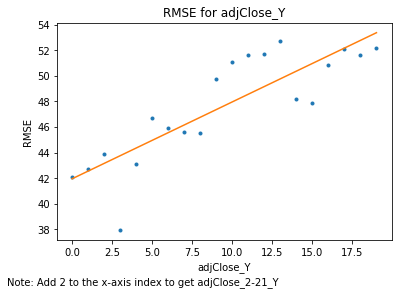

In [8]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [9]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in mae
for i in range(1, len(mae)+1):

    # Print the MAE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the MAE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the MAE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  14.66340866800196
The MAE for adjClose_3_Y =  14.451319020035783
The MAE for adjClose_4_Y =  15.11756585084183
The MAE for adjClose_5_Y =  15.40261094558102
The MAE for adjClose_6_Y =  15.366387687342424
The MAE for adjClose_7_Y =  15.431552315019825
The MAE for adjClose_8_Y =  15.722652669627363
The MAE for adjClose_9_Y =  16.2702993902639
The MAE for adjClose_10_Y =  16.189936858833555
The MAE for adjClose_11_Y =  17.125246943314263
The MAE for adjClose_12_Y =  17.933400215058622
The MAE for adjClose_13_Y =  17.159960455320746
The MAE for adjClose_14_Y =  17.564777477724327
The MAE for adjClose_15_Y =  17.992473067339976
The MAE for adjClose_16_Y =  18.6097588665649
The MAE for adjClose_17_Y =  17.707180000552395
The MAE for adjClose_18_Y =  17.703987935691373
The MAE for adjClose_19_Y =  18.02720132199645
The MAE for adjClose_20_Y =  18.647006629602124
The MAE for adjClose_21_Y =  18.58124913359565
The MAE for 5day_min =  1.399630967321912
The MAE for 10d

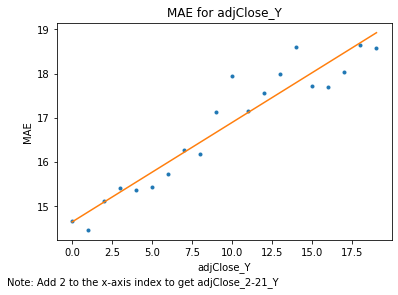

In [10]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('MAE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()